In [109]:
import pandas as pd
import datetime as dt
import time
import numpy as np
import sys

In [110]:
oxford_policy = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")
cols_to_keep = [col for col in list(oxford_policy.columns) if 'Flag' not in col]
oxford_policy = oxford_policy[cols_to_keep]

In [111]:
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'].astype(str), format='%Y%m%d')
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'], infer_datetime_format=True)
oxford_policy['Date'] = oxford_policy['Date'].dt.date
oxford_policy.rename(columns={'CountryName': 'Country'}, inplace=True)

#### data cleaning

### Loading JHU time series dataset

In [112]:
jhu_time = pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv")
jhu_time['Date'] = pd.to_datetime(jhu_time['Date'], infer_datetime_format=True)
jhu_time['Date'] = jhu_time['Date'].dt.date
jhu_time.rename(columns={'Country/Region': 'Country'}, inplace=True)

sub = jhu_time[jhu_time['Confirmed'] > 0.0]
first_case = sub.groupby('Country')['Date'].min().reset_index().sort_values(by=['Country'])
first_case

,Country,Date
0,Afghanistan,2020-02-24
1,Albania,2020-03-09
2,Algeria,2020-02-25
3,Andorra,2020-03-02
4,Angola,2020-03-20
...,...,...
183,West Bank and Gaza,2020-03-05
184,Western Sahara,2020-04-05
185,Yemen,2020-04-10
186,Zambia,2020-03-18


In [114]:
stats = jhu_time.groupby("Country")[['Confirmed', 'Recovered', 'Deaths']].max()
stats[stats.index == 'US']

,Confirmed,Recovered,Deaths
Country,,,
US,1390406.0,243430.0,84119.0


In [ ]:
# Check what countries are missing
ox = oxford_policy['Country'].unique()
jhu = jhu_time['Country'].unique()

[cnt for cnt in jhu if cnt not in ox]


#### cleaning

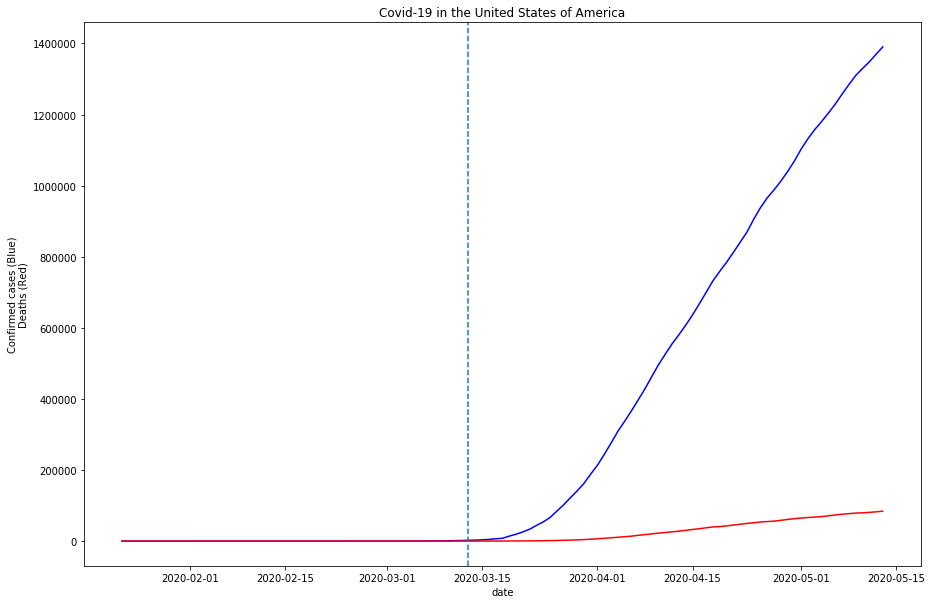

In [116]:
us = jhu_time[jhu_time['Country'] == 'US']
us_soe  = dt.datetime(2020, 3, 13)

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(x=us['Date'], y=us['Confirmed'],  color='blue', ax=ax)
g = sns.lineplot(x=us['Date'], y=us['Deaths'],  color='red', ax=ax)
g.set(xlabel='date', ylabel='Confirmed cases (Blue)\nDeaths (Red)', title='Covid-19 in the United States of America')
#ax.set_yscale('log')
ax.axvline(us_soe, ls='--')
plt.show()


In [117]:
renaming = {'Czech republic': 'Czech Republic', 'Czechia': 'Czech Republic', 'Myanmar': 'Burma', 
          'West Bank and Gaza': 'Palestine', 'Brunei Darussalam': 'Brunei', 'Korea Republic of' : 'South Korea',
          'Korea, Rep.' : 'South Korea', 'Korea, South' : 'South Korea',  'Cote d\'Ivoire': 'Côte d\'Ivoire', 
            'North Macedonia Republic Of': 'North Macedonia', 'Congo': 'Congo (Brazzaville)', 
            'Congo DR': 'Congo (Kinshasa)', 'Congo, Dem. Rep.':'Congo (Kinshasa)',
          "Congo, Rep.":'Congo (Brazzaville)','Democratic Republic of Congo': 'Congo (Kinshasa)',  'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt',
          'Micronesia, Fed. Sts.':'Micronesia','Moldova Republic of': 'Moldova', 'Moldova Republic Of': 'Moldova', 
            'Lao PDR': 'Laos', 'Viet Nam': 'Vietnam', 'US': 'United States of America', "Bahamas, The": "Bahamas",
            "Gambia, The" : "Gambia", 'Iran, Islamic Rep.': "Iran", "Kyrgyzstan": "Kyrgyz Republic", 
            'St. Lucia' : "Saint Lucia", "Slovakia" : "Slovak Republic", 'Syrian Arab Republic' : "Syria", "Taiwan*" : "Taiwan",
           'United States' : 'United States of America', 
            'St. Vincent and the Grenadines' : 'Saint Vincent and the Grenadines', 'Venezuela, RB': 'Venezuela',
            'Yemen, Rep.' : 'Yemen'}

jhu_time['Country'] = jhu_time['Country'].replace(renaming)
oxford_policy['Country'] = oxford_policy['Country'].replace(renaming)

#### Merging Oxford Policy and JHU

In [124]:
merged = pd.merge(oxford_policy, jhu_time, on=['Country', 'Date'], how='left')
merged

,Country,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,...,StringencyIndex,StringencyIndexForDisplay,LegacyStringencyIndex,LegacyStringencyIndexForDisplay,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,Kosovo,RKS,2020-05-09,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,94.71,94.71,93.57,93.57,NaN,42.602636,20.902977,862.0,622.0,28.0
31097,Kosovo,RKS,2020-05-10,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,94.71,94.71,93.57,93.57,NaN,42.602636,20.902977,870.0,653.0,28.0
31098,Kosovo,RKS,2020-05-11,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,94.71,94.71,93.57,93.57,NaN,42.602636,20.902977,884.0,655.0,28.0
31099,Kosovo,RKS,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,94.71,NaN,93.57,NaN,42.602636,20.902977,919.0,671.0,29.0


Creating Curfew dummy column

Getting the date of the first declaration of national emergency. The first declaration measure seems to be a good indicator of
responsiveness, but may need to be explored a bit further.

Cleaning/Preparing World Bank data and merging on larger data frame 

In [126]:
pop_old = pd.read_excel('data/popabove65.xls', sheet_name='Data', header=3, usecols = ["Country Name", "2018"]) 

hbeds = pd.read_excel('data/hospbeds.xls', sheet_name='Data', header=3) 
#hbeds['Country Name'] = hbeds['Country Name'].replace(renaming)

yrs = hbeds[hbeds.columns[4:]]
yrs = yrs.ffill(axis=1)['2019']
wb_data = pd.concat([hbeds['Country Name'], yrs, pop_old['2018']], axis=1)
wb_data.rename(columns={'2019': 'Hospital Beds/1k', 'Country Name': 'Country', '2018': 'Share Pop 65+'}, inplace=True)
wb_data['Country'] = wb_data['Country'].replace(renaming)

countries = pd.merge(merged, wb_data, how='left', on='Country') # tentative left join to not lose country data-- doing an inner would lose us 4 countries
countries

,Country,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,...,LegacyStringencyIndex,LegacyStringencyIndexForDisplay,Province/State,Lat,Long,Confirmed,Recovered,Deaths,Hospital Beds/1k,Share Pop 65+
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.550947
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.550947
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.550947
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.550947
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.550947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,Kosovo,RKS,2020-05-09,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,93.57,93.57,NaN,42.602636,20.902977,862.0,622.0,28.0,NaN,NaN
31097,Kosovo,RKS,2020-05-10,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,93.57,93.57,NaN,42.602636,20.902977,870.0,653.0,28.0,NaN,NaN
31098,Kosovo,RKS,2020-05-11,3.0,2.0,2.0,4.0,2.0,2.0,2.0,...,93.57,93.57,NaN,42.602636,20.902977,884.0,655.0,28.0,NaN,NaN
31099,Kosovo,RKS,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,93.57,NaN,42.602636,20.902977,919.0,671.0,29.0,NaN,NaN
